In [119]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import datetime as dt
import numpy as np
import pandas as pd

# Import SQLAlchemy and other dependencies. 
# Python SQL toolkit and Object Relational Mapper.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [120]:
# Create engine using the `hawaii.sqlite` database file.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [121]:
# Declare a Base using `automap_base()`.
Base = automap_base()

# Reflect the database tables
Base.prepare(engine, reflect=True)

In [122]:
# Print all classes mapped to the Base.
Base.classes.keys()

['measurement', 'station']

In [123]:
# Save each table as their own reference classes.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [124]:
# Create our session (link) from Python to the DB.
session = Session(engine)

In [125]:
# Create the inspector and connect it to the engine
#inspector = inspect(engine)

# Collect the names of tables within the database
#inspector.get_table_names()

In [126]:
# Use 'engine.execute' to select and display the first 10 rows from the table measurement.
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 5').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0)]

In [127]:
# Use 'engine.execute' to select and display the first 10 rows from the table station 
#engine.execute('SELECT * FROM station LIMIT 5').fetchall()

In [128]:
# Create the inspector and connect it to the engine.
inspector = inspect(engine)

# Get a list of column names and types from station.
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [129]:
# Get a list of column names and types from measurement.
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#  Precipitation Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results.

Calculate the date 1 year ago from the last data point in the database.

Perform a query to retrieve the data and precipitation scores.

Save the query results as a Pandas DataFrame and set the index to the date column.

Sort the dataframe by date.

Use Pandas Plotting with Matplotlib to plot the data.

In [130]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
d1 = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
d1

('2017-08-23')

In [131]:
# Calculate the date 1 year ago from the last data point in the database.
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [132]:
# Perform a query to retrieve the data and precipitation scores.
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date).all()

In [133]:
# Load the data from the query into a dataframe.
df = pd.DataFrame(query, columns = ['Date','Precipitation']) 

# Set the index to the date column (sort values by date).
df.set_index('Date')

# Drop null values.
df.dropna(how='any', inplace=True) 
df.tail()

,Date,Precipitation
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08
2229,2017-08-23,0.45


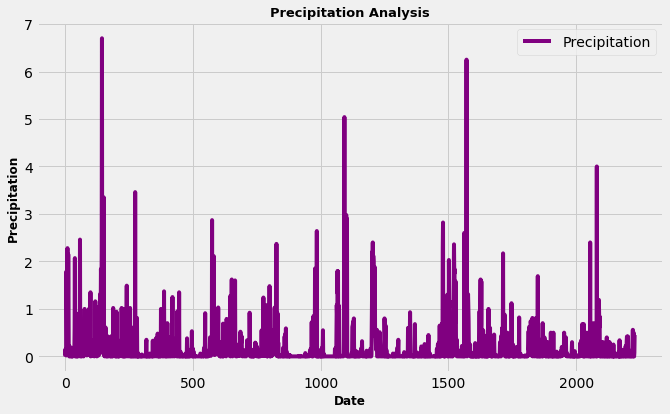

In [134]:
# Plot the data
prcp_plot = df.plot(figsize = (10, 6), sort_columns=True, use_index=True, legend=True, grid=True, color='#800080')
plt.ylabel('Precipitation', weight='bold', fontsize=12)
plt.xlabel('Date', weight='bold', fontsize=12)
plt.title("Precipitation Analysis", weight='bold', fontsize=13)
plt.savefig("Images/Precipitation.png")
plt.show()

In [135]:
# Use Pandas to calculate the summary statistics for the precipitation data.
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [136]:
# Design a query to show how many stations are available in this dataset.
total_stations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(total_stations))

There are 9 stations.


In [137]:
# Find out the most active stations (i.e. what stations have the most rows).
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station, Measurement.id).all()

stations_df= pd.DataFrame(station_rows, columns = ['Station', 'Id'])
most_active_stations = stations_df.groupby(["Station"]).count()
most_active_stations.sort_values(by='Id', ascending=False, inplace=True)
most_active_stations

,Id
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [138]:
# Alternate way of displaying most active stations.
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

active = most_active_stations[0][0]    
print("The most active station was",active,"with",most_active_stations[0][1],"weather observations.")
print()
print("Listed below are all the Stations (in descending order) with their number of observations:")
print()
for station, count in most_active_stations:
    print("Station",station,"had",count, "weather observations.")

The most active station was USC00519281 with 2772 weather observations.

Listed below are all the Stations (in descending order) with their number of observations:

Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [139]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.

low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter_by(station='USC00519281').all()
high_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter_by(station='USC00519281').all()
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter_by(station='USC00519281').all()

print(f'Min temperature was {low_temp}')
print(f'Max temperature was {high_temp}')
print(f'Avg temperature was {avg_temp}')

Min temperature was [('USC00519281', 54.0)]
Max temperature was [('USC00519281', 85.0)]
Avg temperature was [('USC00519281', 71.66378066378067)]


In [140]:
# Choose the station with the highest number of temperature observations.
#Waihee 837.5 has the highest number of observations
waihee_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()


len(waihee_tobs)

352

In [141]:
print(waihee_tobs[0][0])

77.0


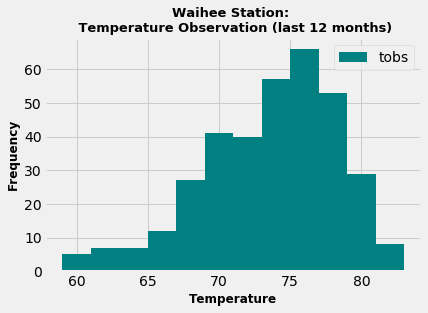

In [142]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = [temp[0] for temp in waihee_tobs]


plt.hist(temperatures, bins=12, color='#008080')
plt.title("Waihee Station: \n Temperature Observation (last 12 months)", weight='bold', fontsize=13)
plt.xlabel('Temperature', weight='bold', fontsize=12)
plt.ylabel('Frequency', weight='bold', fontsize=12)
labels = ['tobs']
plt.legend(labels)
plt.savefig("Images/Station Histogram.png")
plt.show()

In [143]:
# This function called 'calc_temps' will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [144]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# For your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2011-02-28', '2011-03-05')

print(trip_temps)

[(61.0, 69.75510204081633, 75.0)]


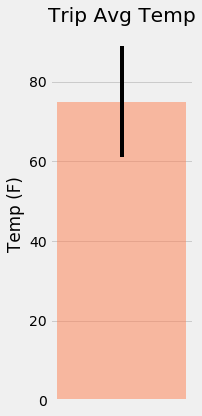

In [145]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp_df=pd.DataFrame(trip_temps, columns=['tmin', 'tavg', 'tmax'])
fig, ax = plt.subplots(figsize = (3, 6))
xpos = 1
yerr = trip_temp_df['tmax'] - trip_temp_df['tmin']

bar = ax.bar(xpos, trip_temp_df['tmax'], yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=[],title="Trip Avg Temp", ylabel="Temp (F)")
fig.tight_layout()
plt.savefig("Images/Temperature.png")
plt.show()

In [146]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-08-23'
end_date = '2016-12-31'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 79.03000000000003), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 26.369999999999994), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 13.889999999999986), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 11.439999999999992), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 10.69), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 5.429999999999995), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.2000000000000002)]
